<a href="https://colab.research.google.com/github/RajkumarGalaxy/ComputerVision/blob/master/DSNE_velocity_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSNE Velocity Visualization

References:

Original research paper
https://arxiv.org/abs/2103.08509v1

Github Repository
https://github.com/songtingstone/dsne


In [ ]:
!pip install dsne

     |████████████████████████████████| 1.3MB 8.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 184kB 33.6MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 122kB 19.3MB/s 
     |████████████████████████████████| 10.3MB 23.5MB/s 
     |████████████████████████████████| 112kB 51.2MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for dsne: filename=dsne-0.1.6-cp37-cp37m-linux_x86_64.whl size=295646 sha256=fa8d9af0d63a30b9b522bce03da6c2feef78302d29f038578ef00c99d7a18d06
  Stored in directory: /root/.cache/pip/wheels/04/0f/04/7e614c9a2592940395b5509e93378a184808c01fcf77a934ac
Successfully built dsne
  Created wheel for umap-learn: filename=umap_learn-0.4.6-cp37-none-any.whl size=67950 sh

## Pancreas data visualization

In [ ]:
import numpy as np
import scvelo as scv
from scipy.sparse import issparse
from dsne import DSNE, DSNE_approximate


In [ ]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
adata = scv.datasets.pancreas()

scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata)


Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [ ]:
def get_X_V_Y(adata,vkey="velocity",
              xkey="Ms",
              basis=None,
              gene_subset=None,
              ):

    subset = np.ones(adata.n_vars, bool)
    if gene_subset is not None:
        var_names_subset = adata.var_names.isin(gene_subset)
        subset &= var_names_subset if len(var_names_subset) > 0 else gene_subset
    elif f"{vkey}_genes" in adata.var.keys():
        subset &= np.array(adata.var[f"{vkey}_genes"].values, dtype=bool)

    xkey = xkey if xkey in adata.layers.keys() else "spliced"
    basis = 'umap' if basis is None else basis
    X = np.array(
        adata.layers[xkey].A[:, subset]
        if issparse(adata.layers[xkey])
        else adata.layers[xkey][:, subset]
    )
    V = np.array(
        adata.layers[vkey].A[:, subset]
        if issparse(adata.layers[vkey])
        else adata.layers[vkey][:, subset]
    )
    # V -= np.nanmean(V, axis=1)[:, None]
    Y =np.array(
        adata.obsm[f"X_{basis}"]
    )


    nans = np.isnan(np.sum(V, axis=0))
    if np.any(nans):
        X = X[:, ~nans]
        V = V[:, ~nans]
    return X,V,Y

In [ ]:
X,V,X_2d = get_X_V_Y(adata,vkey="velocity",xkey="Ms",basis="umap")


V_2d = DSNE(X, V, Y=X_2d,
            perplexity=3.0,
            K=16,
            threshold_V=1e-8,
            separate_threshold=1e-8,
            max_iter=600,
            mom_switch_iter=250,
            momentum=0.5,
            final_momentum=0.8,
            eta=0.1,
            epsilon_kl=1e-16,
            epsilon_dsne=1e-16,
            seed=6,
            random_state=None,
            copy_data=False,
            with_norm=True,
            verbose=True)


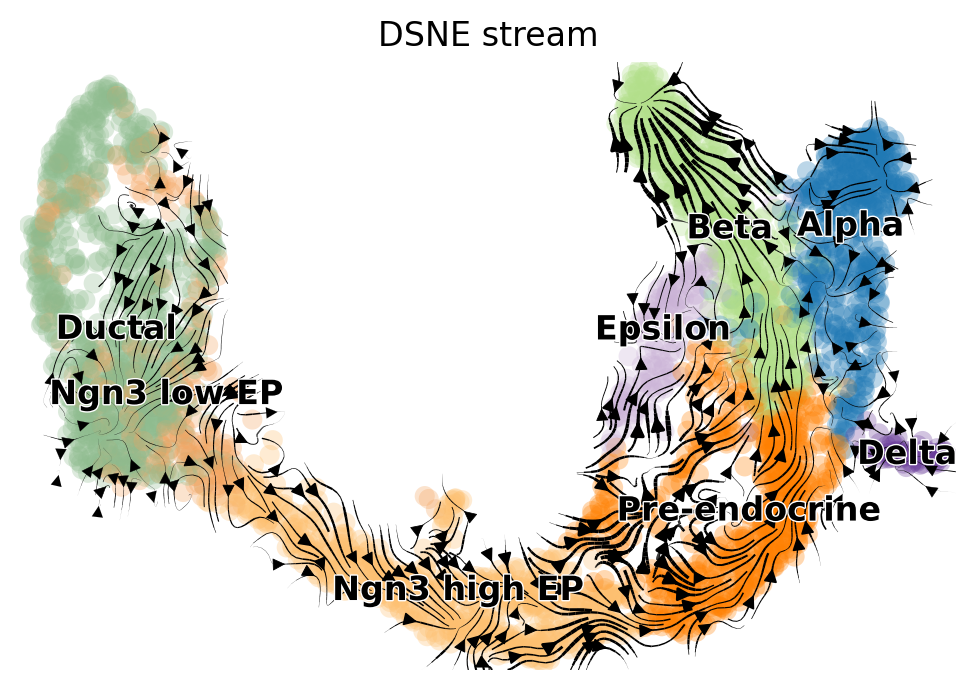

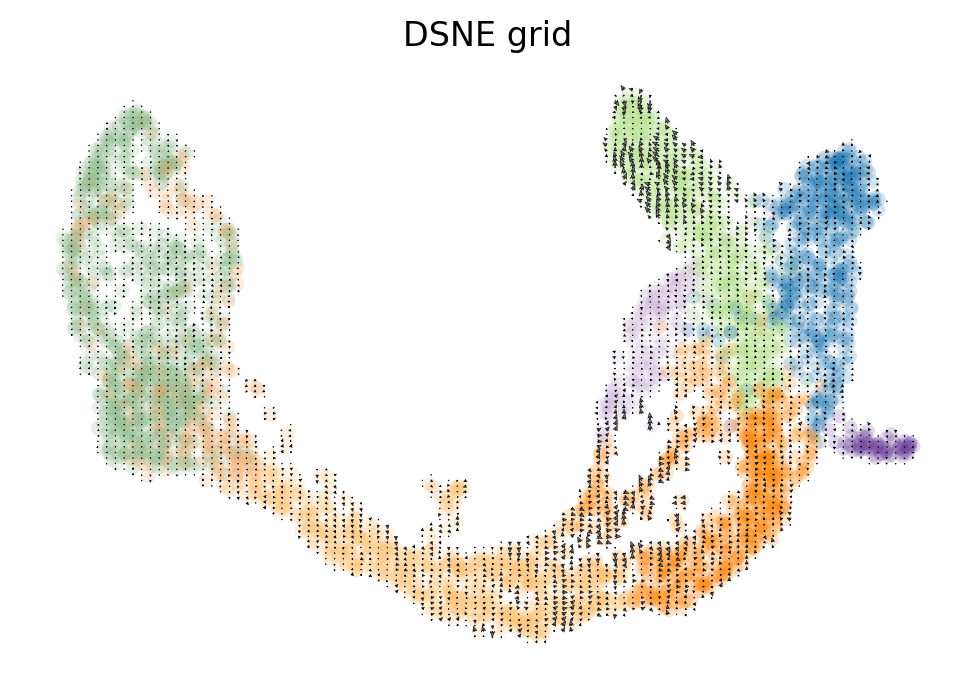

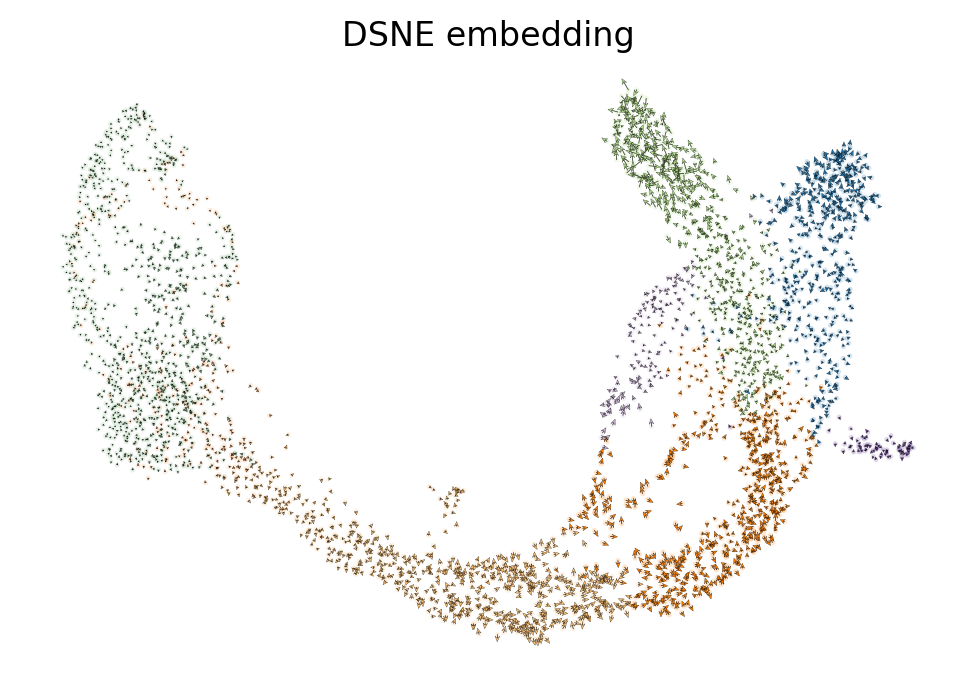

In [ ]:
adata.obsm["X_DSNE"] = X_2d
adata.obsm["V_DSNE"] = V_2d
title ="DSNE"
scv.pl.velocity_embedding_stream(adata, title=title+' stream', basis='umap',V=adata.obsm["V_DSNE"], smooth=0.5,density=2,)

scv.pl.velocity_embedding_grid(adata, title=title+' grid' , basis='umap',V=adata.obsm["V_DSNE"], smooth=0.5,density=2,)


scv.pl.velocity_embedding(adata,  title=title+' embedding',basis='umap',V = adata.obsm["V_DSNE"])



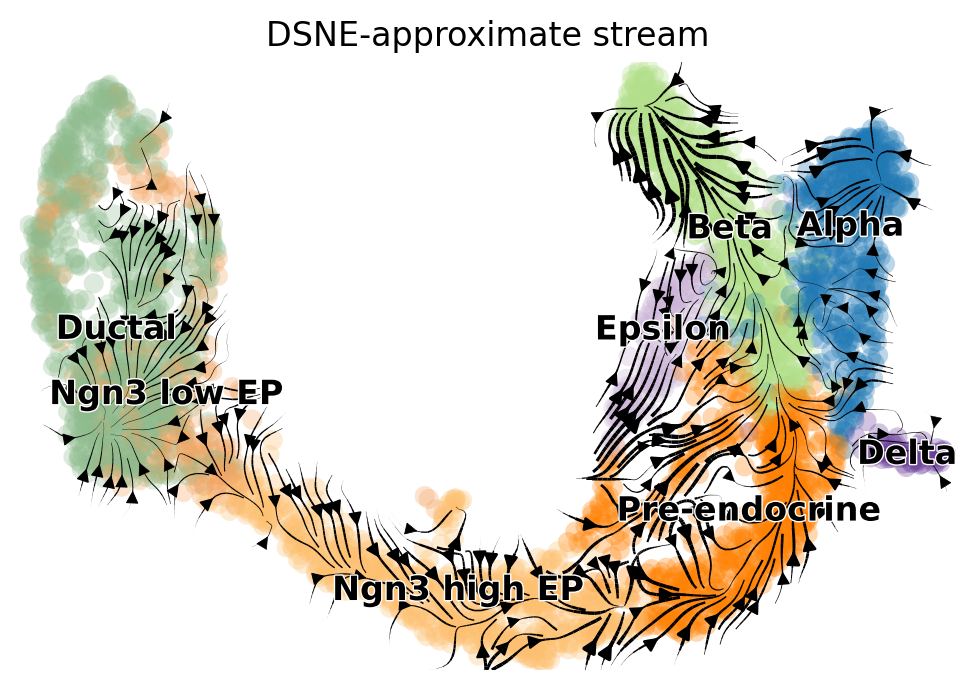

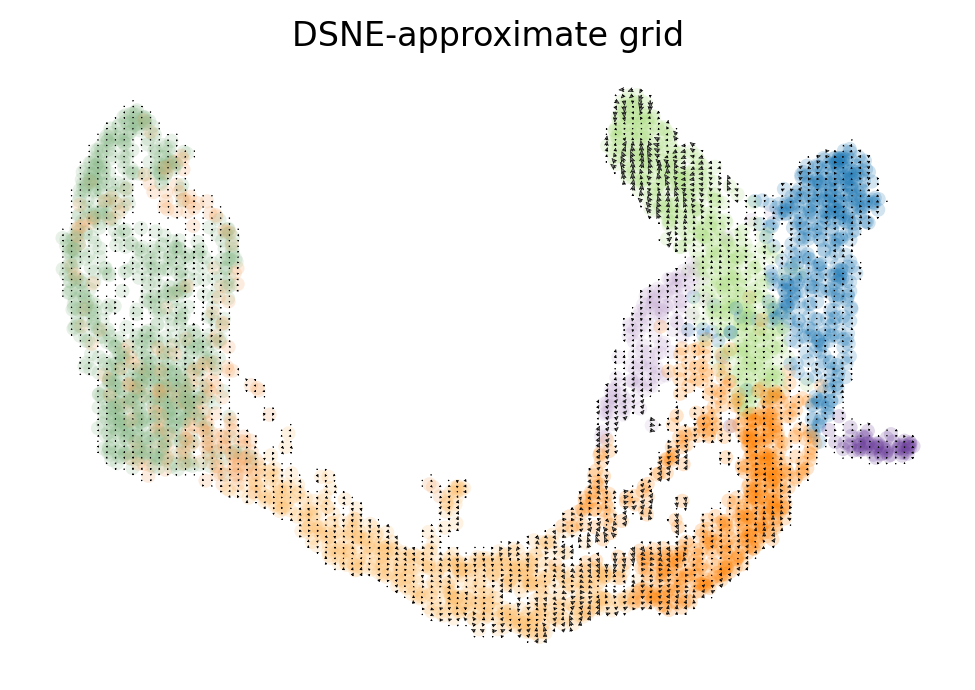

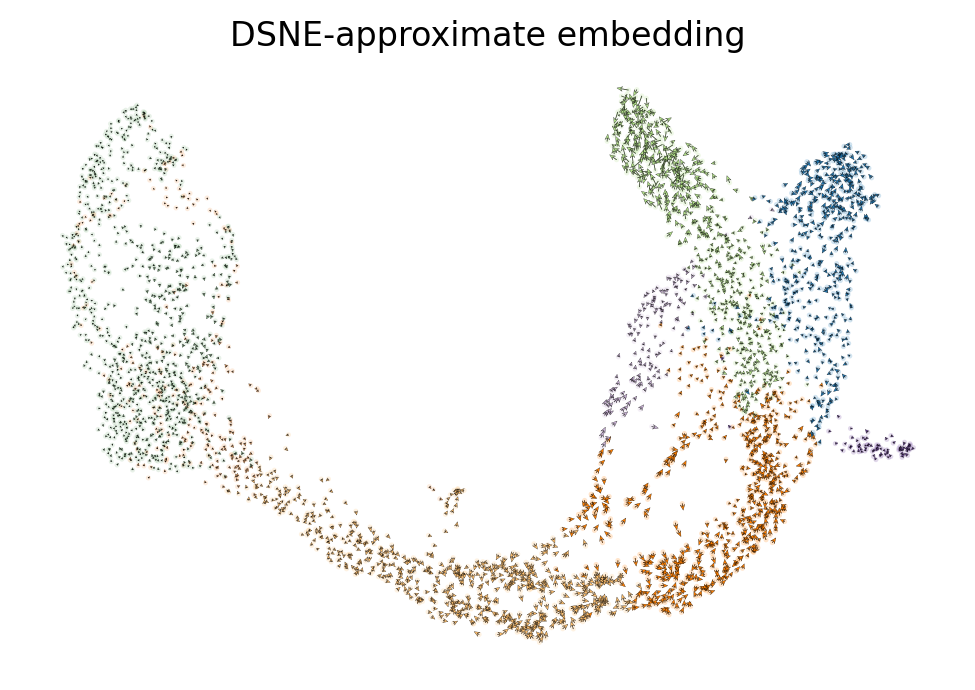

In [ ]:
title ="DSNE-approximate"
V_2d = DSNE_approximate(X, V, Y=X_2d,
                        perplexity=3.0,
                        K=16,
                        threshold_V=1e-8,
                        separate_threshold=1e-8,
                        seed=6,
                        random_state=None,
                        copy_data=False,
                        with_norm=True,
                        verbose=True)

adata.obsm["X_DSNE_approximate"] = X_2d
adata.obsm["V_DSNE_approximate"] = V_2d

scv.pl.velocity_embedding_stream(adata, basis='umap',V=adata.obsm["V_DSNE_approximate"],  title=title+' stream', smooth=0.5,density=2,)

scv.pl.velocity_embedding_grid(adata, basis='umap',V=adata.obsm["V_DSNE_approximate"],  title=title+' grid', smooth=0.5,density=2,)

scv.pl.velocity_embedding(adata, basis='umap',V = adata.obsm["V_DSNE_approximate"], title=title+' embedding')

# Exact Simulation

In [ ]:
import os
import numpy as np
import scvelo as scv
from anndata import AnnData, read_h5ad
from dsne import DSNE, DSNE_approximate

N=500
D=300
d=2
K=16
perplexity =6
n_rep=1
exact = False
with_norm = True
basis = 'exact_embeddings'
verbose = False

def unitLength(V):
    V_ = V/np.sqrt(np.sum(V*V,axis=1,keepdims=True))
    return V_
def velocity_accuracy(V, V_exact):
    V_unit = unitLength(V)
    V_exact_unit = unitLength(V_exact)
    accu = np.sum( V_unit* V_exact_unit )/(V.shape[0]*1.)
    return accu

def simulate_data(N=50, D=3, d=2, save =True, file_name_prefix ="./data" ):
    if not os.path.exists(file_name_prefix):
        print("Directory: {} do not exist, create it! \n".format(os.path.abspath(file_name_prefix)))
        os.makedirs(os.path.abspath(file_name_prefix))
    V_2d = np.random.randn(*(N * 3, d)) * 6
    err_2d = np.random.randn(*(N * 3, d))*2
    x_1 = np.asarray([0, ] * d)
    x_2 = np.asarray([50, ] * d)
    x_3 = np.asarray([160, ] * d)
    X_2d = np.zeros_like(V_2d)
    X_2d[0, :] = x_1
    X_2d[N, :] = x_2
    X_2d[N * 2, :] = x_3
    for i in np.arange(N - 1):
        X_2d[i + 1, :] = X_2d[i, :] + V_2d[i, :] + err_2d[i,:]
        X_2d[i + N + 1, :] = X_2d[i + N, :] + V_2d[i + N, :] + err_2d[i + N, :]
        X_2d[i + N * 2 + 1, :] = X_2d[i + N * 2, :] + V_2d[i + N * 2, :] +  err_2d[i + N * 2, :]


    y = np.asarray([0, ] * N + [1, ] * N + [2, ] * N)
    U = np.array(np.random.randn(*(d, D)))
    X = X_2d.__matmul__(U)
    V = V_2d.__matmul__(U)


    adata = AnnData(X=X, layers={"velocity": V},obs={"clusters": y}, obsm={"X_exact_embeddings":X_2d, "V_exact_embeddings":V_2d})
    if save:
        file_name = file_name_prefix+"simulated_data_N_{}_D_{}.h5hd".format(N,D)
        adata.write_h5ad(file_name)
    return adata


In [ ]:

adata = simulate_data(N=N,D=D,d=d,save=False)
X = adata.X
V = adata.layers["velocity"]
X_basis = f"X_{basis}"

X = np.asarray(X, dtype=np.float64)
V = np.asarray(V, dtype=np.float64)
Y = None
if (X_basis in adata.obsm.keys()) and adata.obsm[X_basis] is not None:
  Y = adata.obsm[f"X_{basis}"]

if Y is None:
  print("Do not get the low dimesnional embedding Y! \n")
  # raise

Y = np.asarray(Y, dtype=np.float64)

## scVelo

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
  scvelo_velocity_original, approx,  accu: 0.961769790544911



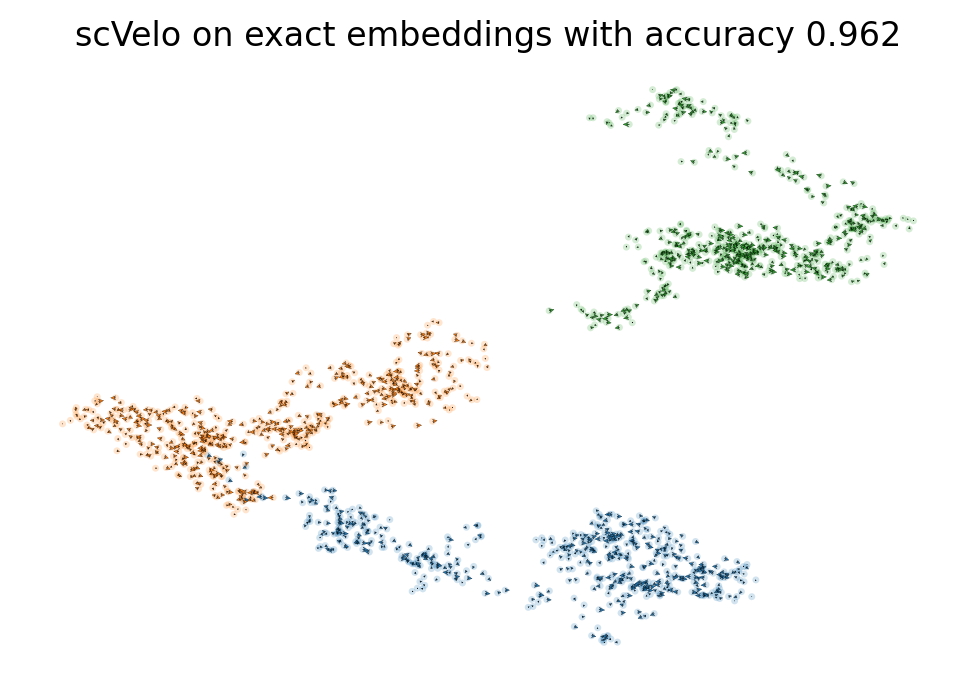

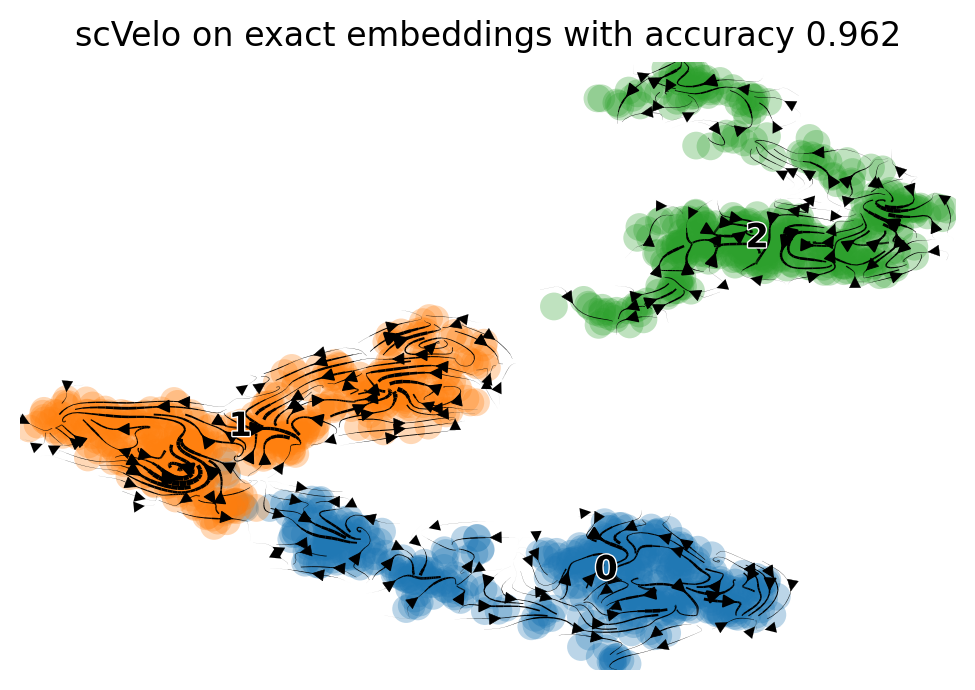

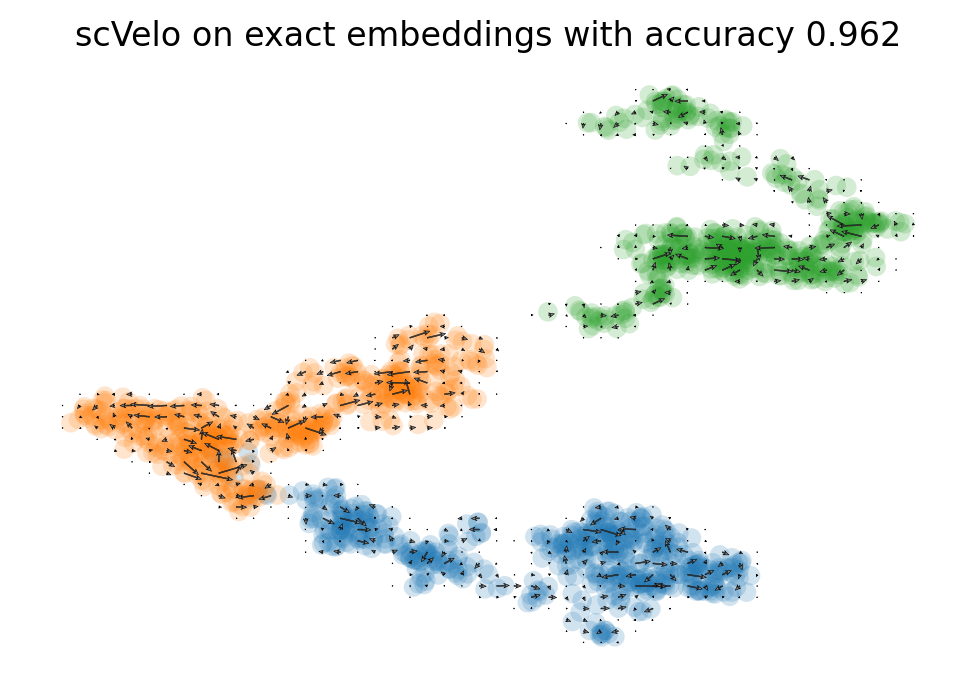

In [ ]:
adata_tmp = AnnData(X=X, obsm={"X_umap": Y}, layers={"velocity": V, "spliced": X})
scv.tl.velocity_graph(adata_tmp, xkey='spliced')
scv.tools.velocity_embedding(adata_tmp, basis="umap")
W = adata_tmp.obsm["velocity_umap"]
vkey = "velocity_scvelo_original"
method = 'scvelo_velocity_original'
str_exact = "exact" if exact else "approx"
adata.obsm[f"{vkey}_{str_exact}_{basis}"] = W
W_exact = adata.obsm["V_exact_embeddings"]
accu = velocity_accuracy(W, W_exact)
print(f"  {method}, {str_exact},  accu: {accu}\n")
method_str = "scVelo"
title = "{} on exact embeddings with accuracy {:5.3f}".format(method_str, accu)
scv.pl.velocity_embedding(adata, basis=basis, V=W, title=title,density=2,)
scv.pl.velocity_embedding_stream(adata, basis=basis, V=W, title=title,density=2,)
scv.pl.velocity_embedding_grid(adata, basis=basis, V=W, title=title,)

## DSNE Approximate

  DSNE_approximate, approx,  accu: 0.9789126025613871



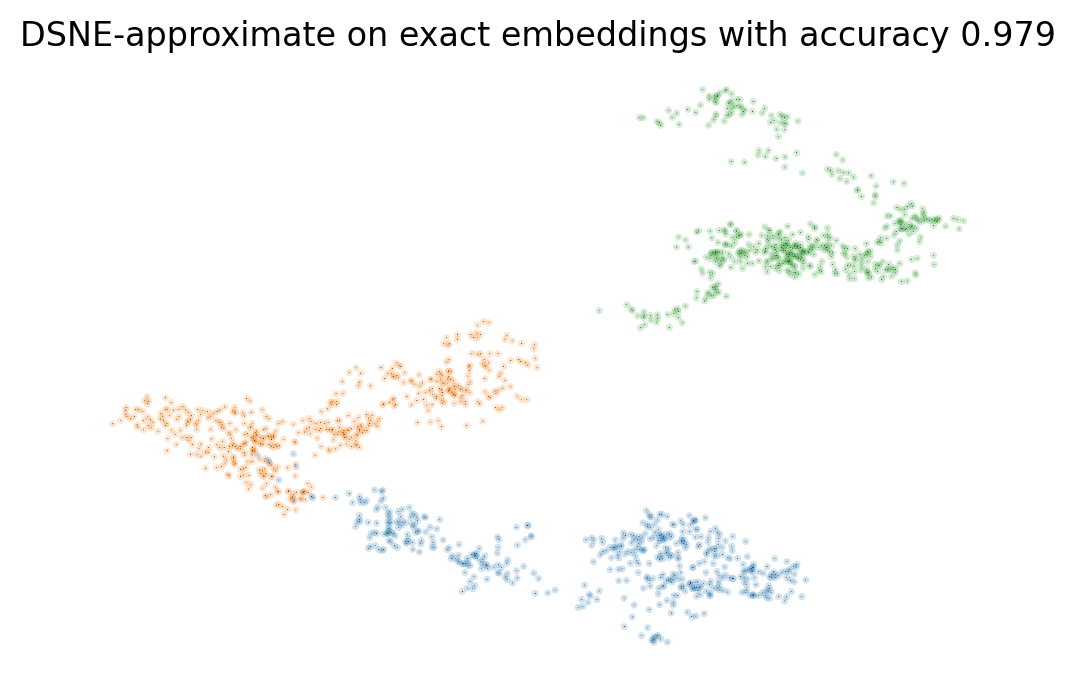

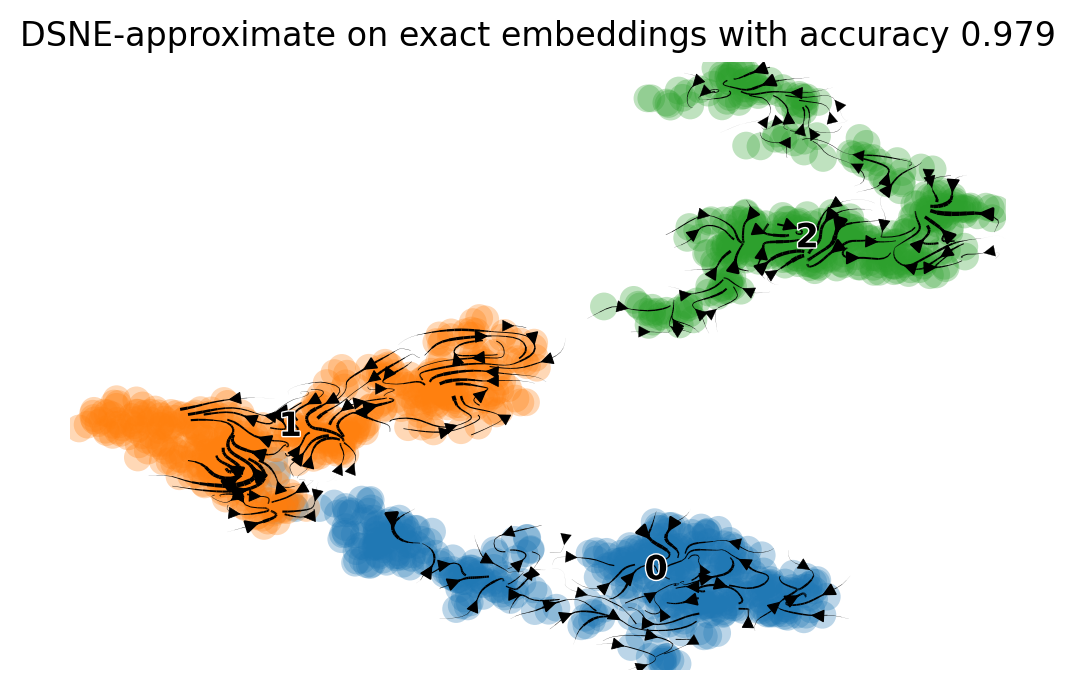

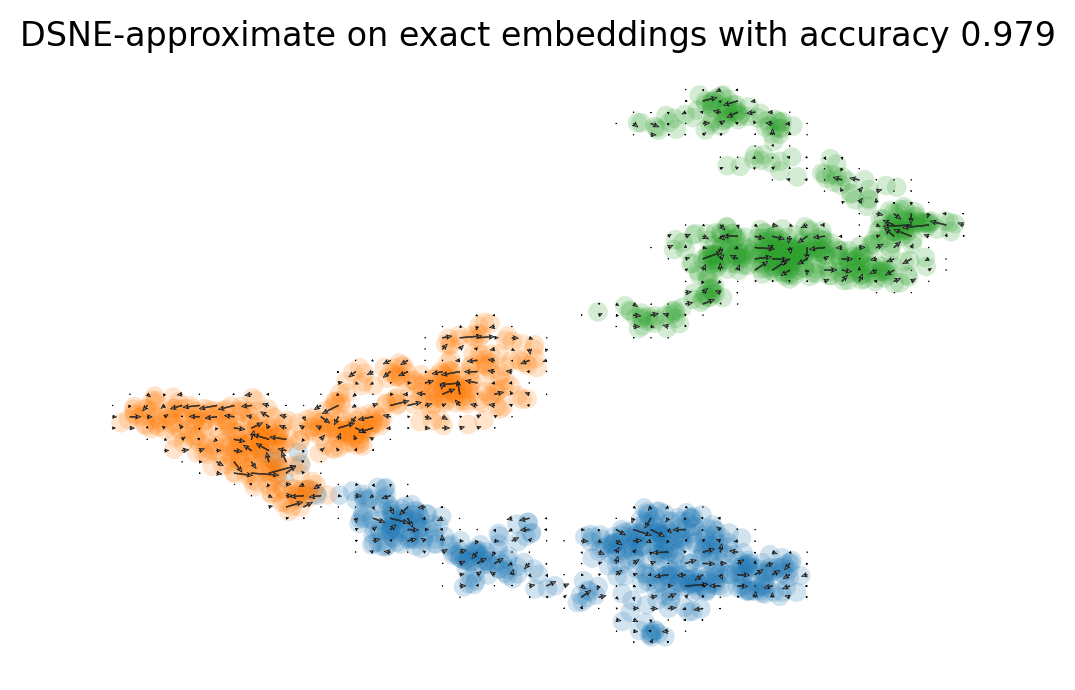

In [ ]:
W = DSNE_approximate(X, V, Y=Y,
                                      perplexity=perplexity,
                                      pca_d=None,
                                      threshold_V=1e-8,
                                      separate_threshold=1e-8,
                                      seed=16,
                                      random_state=None,
                                      copy_data=False,
                                      verbose=verbose)
vkey = "velocity_scvelo"
str_exact = "exact" if exact else "approx"
method = "DSNE_approximate"
adata.obsm[f"{vkey}_{str_exact}_{basis}"] = W
W_exact = adata.obsm["V_exact_embeddings"]
accu = velocity_accuracy(W, W_exact)
print(f"  {method}, {str_exact},  accu: {accu}\n")
method_str = "DSNE-approximate"
title = "{} on exact embeddings with accuracy {:5.3f}".format(method_str, accu)
scv.pl.velocity_embedding(adata, basis=basis, V=W, title=title,density=2,)
scv.pl.velocity_embedding_stream(adata, basis=basis, V=W, title=title,density=2,)
scv.pl.velocity_embedding_grid(adata, basis=basis, V=W, title=title,)

## DSNE

  DSNE, approx,  accu: 0.9956825029228583



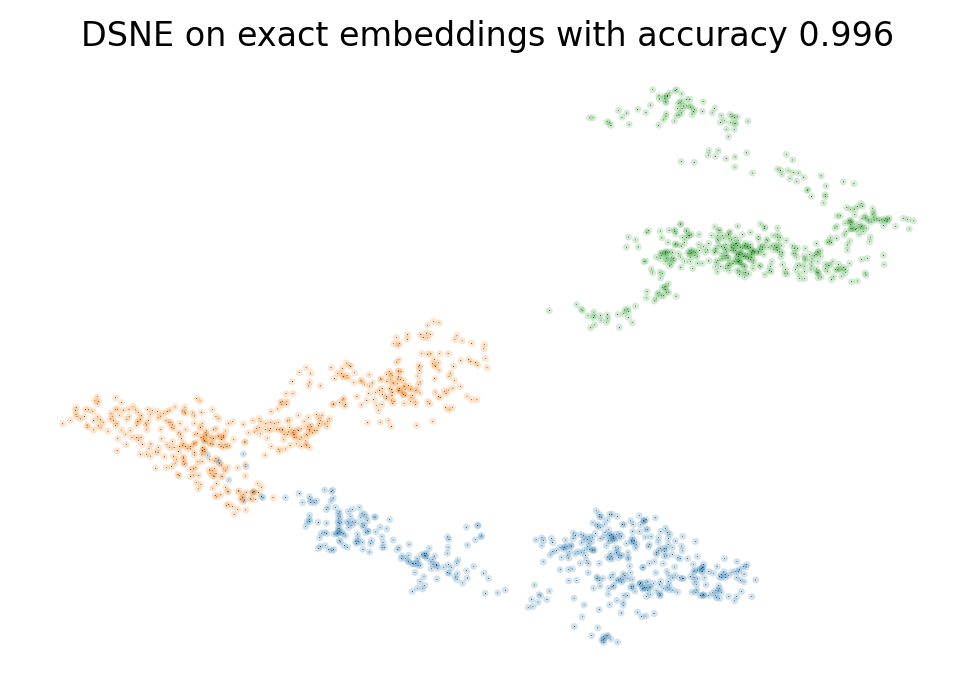

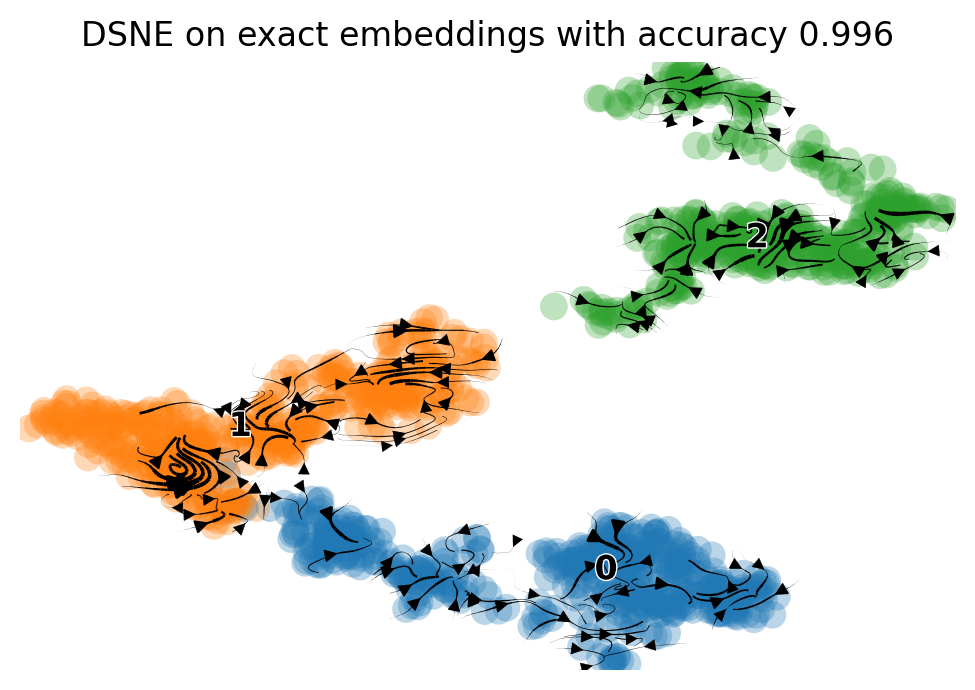

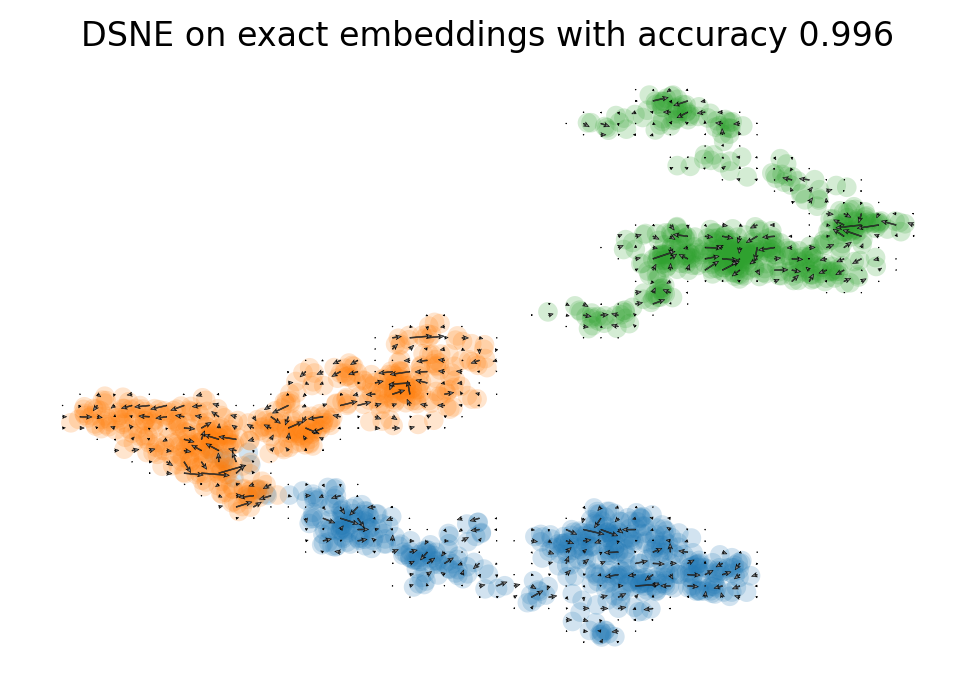

In [ ]:
W = DSNE(X, V, Y=Y,
                 K= K,
                 perplexity=perplexity,
                 pca_d=None,
                 threshold_V=1e-8,
                 separate_threshold=1e-8,
                 max_iter=1000,
                 mom_switch_iter=250,
                 momentum=0.5,
                 final_momentum=0.8,
                 eta=0.1,
                 epsilon_kl=1e-16,
                 epsilon_dsne=1e-16,
                 with_norm=with_norm,
                 seed=16,
                 random_state=None,
                 copy_data=True,
                 verbose=verbose)
vkey = "velocity_dsne"
method = 'DSNE'
str_exact = "exact" if exact else "approx"
adata.obsm[f"{vkey}_{str_exact}_{basis}"] = W
W_exact = adata.obsm["V_exact_embeddings"]
accu = velocity_accuracy(W, W_exact)
print(f"  {method}, {str_exact},  accu: {accu}\n")
method_str = "DSNE"
title = "{} on exact embeddings with accuracy {:5.3f}".format(method_str, accu)
scv.pl.velocity_embedding(adata, basis=basis, V=W, title=title,density=2,)
scv.pl.velocity_embedding_stream(adata, basis=basis, V=W, title=title,density=2,)
scv.pl.velocity_embedding_grid(adata, basis=basis, V=W, title=title,)

## Thank you for your time!